Loading Data (Eastern Province Analysis)...

✅ JSON EXPORT SUCCESS: eastern_province_earnings.json
           More than him  Less than him  About the same  \
Location                                                  
Rwamagana           11.1           58.3            26.4   
Nyagatare            4.5           59.5            29.8   
Gatsibo             10.7           51.7            36.9   
Kayonza              9.2           58.2            31.3   
Kirehe              11.0           50.8            36.0   
Ngoma                8.5           44.3            45.9   
Bugesera            10.3           57.6            30.7   
East                 8.8           54.8            33.7   
Rwanda              12.2           58.7            26.0   

           Husband has no earnings  
Location                            
Rwamagana                      4.2  
Nyagatare                      6.3  
Gatsibo                        0.6  
Kayonza                        1.2  
Kirehe                       

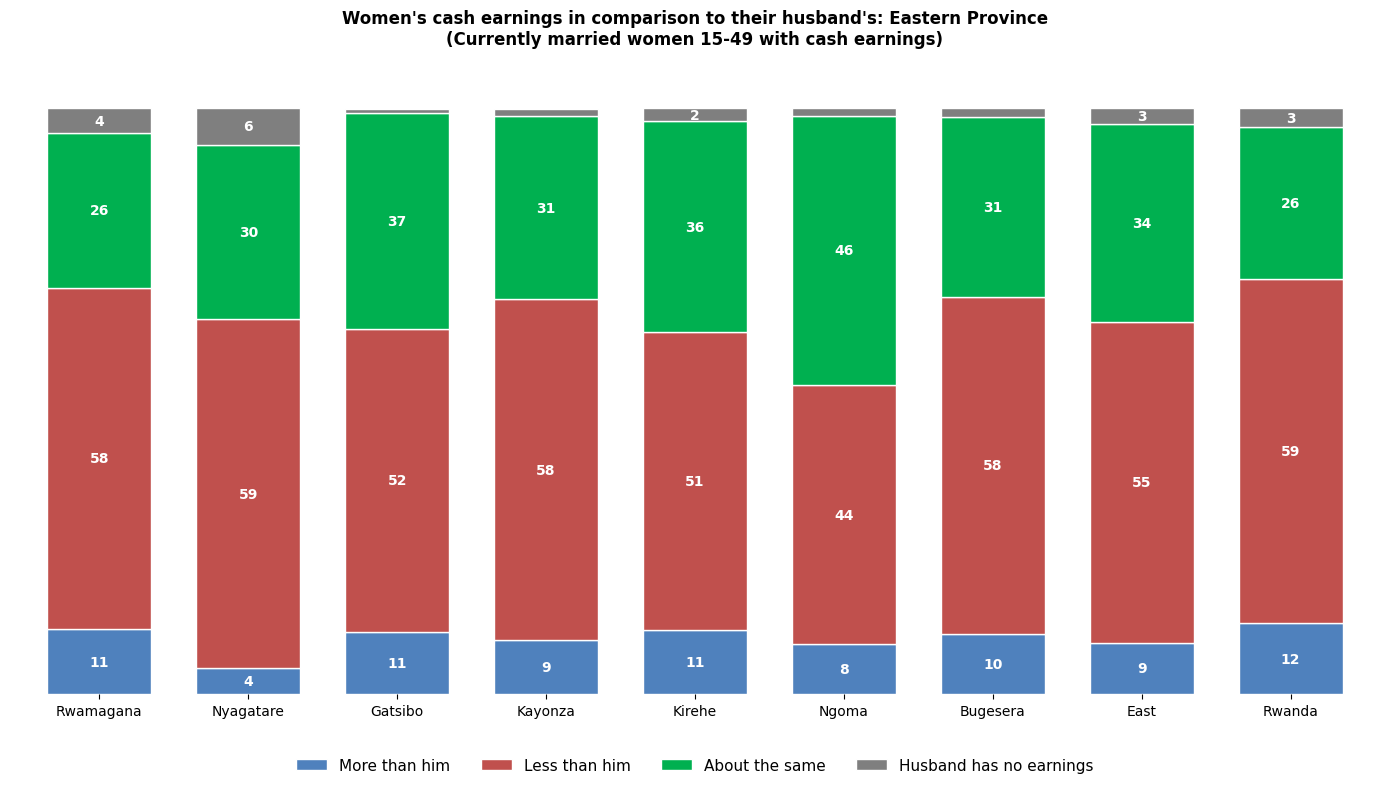

In [5]:
#!/usr/bin/env python3
# dhs_women_earnings_eastern_ordered.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json

# ------------------------------------------------------------------
# 1. SETTINGS & MAPPING (Eastern Province Order)
# ------------------------------------------------------------------
FILE_WOMEN = os.path.join("data", "RWIR81FL.DTA")

# Mapping v023 codes to Eastern Province Districts
EASTERN_MAP = {
    47: "Rwamagana", 48: "Rwamagana",
    49: "Nyagatare", 50: "Nyagatare",
    51: "Gatsibo",   52: "Gatsibo",
    53: "Kayonza",   54: "Kayonza",
    55: "Kirehe",    56: "Kirehe",
    57: "Ngoma",     58: "Ngoma",
    59: "Bugesera",  60: "Bugesera"
}

# The specific requested order
DISTRICT_ORDER = [
    "Rwamagana", "Nyagatare", "Gatsibo", "Kayonza", 
    "Kirehe", "Ngoma", "Bugesera"
]

def process_eastern_earnings_magnitude():
    if not os.path.exists(FILE_WOMEN):
        print(f"❌ Error: File not found at {FILE_WOMEN}")
        return
    
    print("Loading Data (Eastern Province Analysis)...")
    # Load required columns
    cols = ['v005', 'v012', 'v024', 'v023', 'v502', 'v746']
    df = pd.read_stata(FILE_WOMEN, columns=cols, convert_categoricals=False)
    df.columns = df.columns.str.lower()

    # 1. Apply DHS Weights
    df['w'] = df['v005'] / 1000000.0
    
    # 2. FILTER: Currently married women 15-49 with cash earnings (v746)
    # v746 codes: 1=More than him, 2=Less than him, 3=About the same, 4=Husband no earnings
    valid_earnings_codes = [1, 2, 3, 4]
    df = df[(df['v502'] == 1) & 
            (df['v012'].between(15, 49)) & 
            (df['v746'].isin(valid_earnings_codes))].copy()

    # 3. Create Indicators for Earnings Comparison
    df['More than him'] = (df['v746'] == 1).astype(int)
    df['Less than him'] = (df['v746'] == 2).astype(int)
    df['About the same'] = (df['v746'] == 3).astype(int)
    df['Husband has no earnings'] = (df['v746'] == 4).astype(int)

    # 4. Filter for Eastern Province (Province Code 5)
    df['dist_name'] = df['v023'].map(EASTERN_MAP)
    df_eastern = df[df['v024'] == 5].copy()
    
    categories = ['More than him', 'Less than him', 'About the same', 'Husband has no earnings']
    
    results = []
    
    # Aggregate in the specific requested order
    for name in DISTRICT_ORDER + ["East", "Rwanda"]:
        if name == "Rwanda":
            subset = df
        elif name == "East":
            subset = df_eastern
        else:
            subset = df_eastern[df_eastern['dist_name'] == name]
        
        if subset.empty:
            continue

        row = {'Location': name}
        weights = subset['w']
        for cat in categories:
            # Weighted average converted to percentage
            row[cat] = float(np.average(subset[cat], weights=weights) * 100)
        results.append(row)
    
    # Create DataFrame and round
    final_df = pd.DataFrame(results).set_index('Location').round(1)

    # --------------------------------------------------------------
    # 5. JSON OUTPUT
    # --------------------------------------------------------------
    json_filename = "eastern_province_earnings.json"
    final_df.to_json(json_filename, orient='index', indent=4)
    
    print("\n" + "="*60)
    print(f"✅ JSON EXPORT SUCCESS: {json_filename}")
    print("="*60)
    print(final_df)

    # --------------------------------------------------------------
    # 6. PLOTTING
    # --------------------------------------------------------------
    # Colors matching Figure 45 style: Blue, Red, Green, Gray/Purple
    colors = ["#4F81BD", "#C0504D", "#00B050", "#7F7F7F"]
    ax = final_df.plot(kind="bar", stacked=True, figsize=(14, 8), color=colors, width=0.7, edgecolor="white")
    
    plt.title("Women's cash earnings in comparison to their husband's: Eastern Province\n(Currently married women 15-49 with cash earnings)", 
              fontsize=12, fontweight="bold", pad=25)
    
    plt.xticks(rotation=0, fontsize=10)
    plt.xlabel("")
    ax.yaxis.set_visible(False)
    for s in ['top', 'right', 'left', 'bottom']: ax.spines[s].set_visible(False)
    
    # Add numeric labels inside the bar segments
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        if height > 2: # Only label segments larger than 2% for readability
            x, y = p.get_xy() 
            ax.text(x + width/2, y + height/2, f"{int(round(height))}", 
                    ha='center', va='center', color='white', fontweight='bold', fontsize=10)

    plt.legend(bbox_to_anchor=(0.5, -0.15), loc='lower center', ncol=4, frameon=False, fontsize=11)
    plt.tight_layout()
    
    # Save image
    plt.savefig("eastern_earnings_magnitude.png", dpi=300, bbox_inches='tight')
    print(f"📊 Chart saved as 'eastern_earnings_magnitude.png'")
    plt.show()

if __name__ == "__main__":
    process_eastern_earnings_magnitude()